In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [6]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys

import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

# from scipy.signal._signaltools import _centered
# sys.modules['scipy.signal.signaltools._centered'] = _centered

from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

import six
import sys
sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = _safe_indexing

from pairs_trading_package.clustering import *

import pairs_trading_package as lfl
from pairs_trading_package.utils import flatten

random_state=42

In [7]:
import pylab as plb
plb.rcParams['font.size'] = 12
plb.rcParams["savefig.bbox"] = 'tight'

In [8]:
# # import glob; glob.glob('./**.csv' )

# meta_data_files = ['./e22caf5b3a425f3a6192dc01c6d68fed.csv']

# working_df = pd.DataFrame()

# for fl in meta_data_files:
#     temp_df = pd.read_csv(fl)
#     working_df = pd.concat([working_df, temp_df])

# working_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# working_df.reset_index(drop=True, inplace=True)
# working_df.drop_duplicates(inplace=True)
# working_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# # working_df.dropna(inplace=True)

In [9]:
# working_df.to_csv('./working_df_final.csv')

In [11]:
# regime_time_columns = ['train_start', 'train_end', 'test_start', 'test_end', 'validation_date']

# regime_df = pd.read_csv('./market_features.csv')
# regime_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# working_df.loc[:, list(regime_df.columns[~regime_df.columns.isin(regime_time_columns)])] = 0.0

# for regime_row in regime_df.iterrows():
#     selected_rows = working_df.loc[pd.to_datetime(working_df['train_period_start']) == pd.to_datetime(regime_row[1]['train_start'])].index 

#     if len(selected_rows) != 0:
#         for sel_attr in list(regime_df.columns[~regime_df.columns.isin(regime_time_columns)]):
#             for sel_idx in selected_rows:
#                 working_df.at[sel_idx, sel_attr] = regime_df.loc[pd.to_datetime(regime_df['train_start']) == pd.to_datetime(regime_row[1]['train_start']), sel_attr].values


In [12]:
# working_df.to_csv('./meta_e22caf5b3a425f3a6192dc01c6d68fed.csv')

In [13]:
working_df = pd.read_csv('./meta_e22caf5b3a425f3a6192dc01c6d68fed.csv')

working_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [77]:
columns_to_ignore = ['avg_total_roi_insample', 'pvalue_threshold', 'seed',
                     'hurst_threshold', #'distance_measure',
                     'min_zero_crossings', 'qvalue_threshold',
                     'multiple_hypothesis_correction_method', 'explained_variance',
                     'n_clusters', 'n_principal_components',
                     
                     'portfolio_returns_saved_file_insample', 'spreads_saved_file_insample',
                     'portfolio_returns_saved_file_oosample', 'spreads_saved_file_oosample',
                     'dimensionality_reduction_method', 'no_found_pairs_from_clustering',
                    
                     'count_coint_pvals_dist', 'mean_coint_pvals_dist', 'std_coint_pvals_dist', 
                     'min_coint_pvals_dist', '25%_coint_pvals_dist', '50%_coint_pvals_dist',
                     '75%_coint_pvals_dist', 'max_coint_pvals_dist',
                    
                     'clust_algo']
                     
time_period_columns = ['train_period_start',	'train_period_end',	'test_period_start',
                       'test_period_end', 'validation_period']

oos_columns = ['n_pairs_oosample', 'annual_sharpe_ratio_iid_oosample', 'auto_corr_oosample', 
    'daily_sharpe_ratio_oosample', 'portfolio_vol_oosample', 'avg_total_roi_oosample', 'avg_annual_roi_oosample',
    'total_trades_oosample', 'positive_trades_oosample', 'negative_trades_oosample', 'pct_positive_trades_per_pair_oosample',
    'pct_pairs_with_positive_results_oosample', 'max_dd_oosample', 'max_dd_duration_oosample', 'total_dd_duration_oosample', 
    'avg_half_life_oosample', 'avg_hurst_exponent_oosample', 'count_positive_trades_dist_oosample', 'mean_positive_trades_dist_oosample', 
    'std_positive_trades_dist_oosample', 'min_positive_trades_dist_oosample', '25%_positive_trades_dist_oosample', 
    '50%_positive_trades_dist_oosample', '75%_positive_trades_dist_oosample', 'max_positive_trades_dist_oosample', 
    'count_negative_trades_dist_oosample', 'mean_negative_trades_dist_oosample', 'std_negative_trades_dist_oosample',
    'min_negative_trades_dist_oosample', '25%_negative_trades_dist_oosample', '50%_negative_trades_dist_oosample', 
    '75%_negative_trades_dist_oosample', 'max_negative_trades_dist_oosample', 'count_pairs_sharpe_dist_oosample', 
    'mean_pairs_sharpe_dist_oosample', 'std_pairs_sharpe_dist_oosample', 'min_pairs_sharpe_dist_oosample', '25%_pairs_sharpe_dist_oosample', 
    '50%_pairs_sharpe_dist_oosample', '75%_pairs_sharpe_dist_oosample', 'max_pairs_sharpe_dist_oosample']

is_columns = [
    'annual_sharpe_ratio_iid_insample', 'daily_sharpe_ratio_insample', 'avg_total_roi_insample', 
              'avg_annual_roi_insample', 'max_dd_insample', 'max_dd_duration_insample', 'total_dd_duration_insample',
              'auto_corr_insample', 'n_pairs_insample', 'portfolio_vol_insample', 
    'total_trades_insample', 'positive_trades_insample',
    'negative_trades_insample', 
              'pct_positive_trades_per_pair_insample', 'pct_pairs_with_positive_results_insample', 
     'avg_half_life_insample', 
    'avg_hurst_exponent_insample', 
              'count_positive_trades_dist_insample', 'mean_positive_trades_dist_insample', 
    'std_positive_trades_dist_insample', 'min_positive_trades_dist_insample', '25%_positive_trades_dist_insample', 
    '50%_positive_trades_dist_insample', '75%_positive_trades_dist_insample', 'max_positive_trades_dist_insample', 
    'count_negative_trades_dist_insample', 'mean_negative_trades_dist_insample', 'std_negative_trades_dist_insample', 
    'min_negative_trades_dist_insample', '25%_negative_trades_dist_insample', '50%_negative_trades_dist_insample', 
    '75%_negative_trades_dist_insample', 'max_negative_trades_dist_insample', 'count_pairs_sharpe_dist_insample', 
    'mean_pairs_sharpe_dist_insample', 'std_pairs_sharpe_dist_insample', 'min_pairs_sharpe_dist_insample', 
    '25%_pairs_sharpe_dist_insample', '50%_pairs_sharpe_dist_insample', '75%_pairs_sharpe_dist_insample', 
    'max_pairs_sharpe_dist_insample'
             ]



corr_cull_columns = [# 'corr_coeffs_1%', 'corr_coeffs_10%',
#        'corr_coeffs_10-1', 'corr_coeffs_25%', 'corr_coeffs_50%',
#        'corr_coeffs_75%', 'corr_coeffs_90%', 'corr_coeffs_99%',
#        'corr_coeffs_99-90', 'corr_coeffs_max', 'corr_coeffs_mean',
#        'corr_coeffs_min', 'corr_coeffs_std', 'corr_condition_number',
#        'corr_coph_average', 'corr_coph_complete', 'corr_coph_single',
       'corr_determinant',
#     'corr_eigen_gini', 'corr_varex_30-5',
#        'corr_varex_5-1', 'corr_varex_eig1', 'corr_varex_eig_MP',
#        'corr_varex_eig_top30', 'corr_varex_eig_top5',
       'mst_average_node_connectivity',
#        'mst_avg_shortest',
#        'mst_closeness_centrality_25%', 'mst_closeness_centrality_50%',
#        'mst_closeness_centrality_75%', 'mst_closeness_centrality_max',
#        'mst_closeness_centrality_mean', 'mst_closeness_centrality_min',
#        'mst_closeness_centrality_std', 'mst_edges',
#        'mst_normalised_tree_length', 'pf_25%', 'pf_50%', 'pf_75%', 'pf_max',
#        'pf_mean', 'pf_min', 'pf_std', 
#        'acf_mean', 'acf_std', 'acf_min', 'acf_25%', 'acf_50%', 'acf_75%',
       'acf_max', 
#         'returns_mean', 'returns_std', 'returns_min', 'returns_25%',
#        'returns_50%', 'returns_75%', 'returns_max', 'sharpe_benchmark',
       'is_normal'
]

categorical_columns = ['distance_measure'] #'clust_algo', 


In [78]:
algo_specific_df = working_df.copy()[working_df['clust_algo'] == 'spectral']
algo_specific_df['annual_sharpe_ratio_iid_oosample'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
le.fit(algo_specific_df['distance_measure'])
algo_specific_df['distance_measure'] = le.transform(algo_specific_df['distance_measure'])


In [79]:
from sklearn.preprocessing import QuantileTransformer

sharpe_target_label = pd.Series(np.zeros(len(algo_specific_df['annual_sharpe_ratio_iid_oosample'])))

bigger_than_zero_values = algo_specific_df['annual_sharpe_ratio_iid_oosample'][algo_specific_df['annual_sharpe_ratio_iid_oosample'] > 0]
bigger_than_zero_index = np.where(algo_specific_df['annual_sharpe_ratio_iid_oosample'] > 0)[0]

std_scaler = QuantileTransformer(random_state=random_state)
std_scaler.fit(bigger_than_zero_values.values.reshape(-1, 1))

scaled_pair_counts = std_scaler.transform(bigger_than_zero_values.values.reshape(-1, 1))

from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
est.fit(scaled_pair_counts) 

sharpe_target_label.iloc[bigger_than_zero_index] = est.transform(scaled_pair_counts).reshape(-1)+1 

sharpe_target_label.value_counts()

0.0    3079
3.0    1681
1.0    1680
2.0    1680
dtype: int64

In [80]:

from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=random_state)
algo_specific_df, _ = rus.fit_resample(algo_specific_df, sharpe_target_label) #algo_specific_df[low_val_mask], balanced_sampling_target[low_val_mask])

# algo_specific_df

In [81]:
# How does clustering algorithm perform?
feature_df = algo_specific_df.loc[:, ~algo_specific_df.columns.isin(columns_to_ignore + time_period_columns + oos_columns + is_columns + corr_cull_columns)].copy()

In [82]:
from sklearn.preprocessing import QuantileTransformer

std_scaler = QuantileTransformer(random_state=random_state)
std_scaler.fit(algo_specific_df['annual_sharpe_ratio_iid_oosample'].values.reshape(-1, 1))

target_label = pd.Series(std_scaler.transform(algo_specific_df['annual_sharpe_ratio_iid_oosample'].values.reshape(-1, 1)).reshape(-1))

target_label

0       0.132633
1       0.132633
2       0.132633
3       0.132633
4       0.132633
          ...   
6715    0.824075
6716    0.791359
6717    0.781756
6718    0.975427
6719    0.880881
Length: 6720, dtype: float64

In [83]:
# from imblearn.under_sampling import RandomUnderSampler 

# rus = RandomUnderSampler(random_state=42)
resampled_feature_df, resampled_target_label = feature_df, target_label #rus.fit_resample(feature_df, target_label)


In [87]:
from sklearn.model_selection import train_test_split

xtrain, xvalidate, ytrain, yvalidate = train_test_split(resampled_feature_df, resampled_target_label, test_size=0.3, random_state=random_state)


In [88]:
# ytrain.value_counts(), yvalidate.value_counts()

In [89]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

xtrain_without_categorical = xtrain.loc[:, ~xtrain.columns.isin(categorical_columns)]
xtrain_without_categorical.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

xvalidate_without_categorical = xvalidate.loc[:, ~xvalidate.columns.isin(categorical_columns)]
xvalidate_without_categorical.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

scaler = StandardScaler()
scaler.fit(xtrain_without_categorical)

xtrain_scaled = pd.DataFrame(data=scaler.transform(xtrain_without_categorical), columns=xtrain_without_categorical.columns)
xvalidate_scaled = pd.DataFrame(data=scaler.transform(xvalidate_without_categorical), columns=xvalidate_without_categorical.columns)

xtrain_scaled.loc[:, categorical_columns] = xtrain.loc[:, categorical_columns].values
xvalidate_scaled.loc[:, categorical_columns] = xvalidate.loc[:, categorical_columns].values


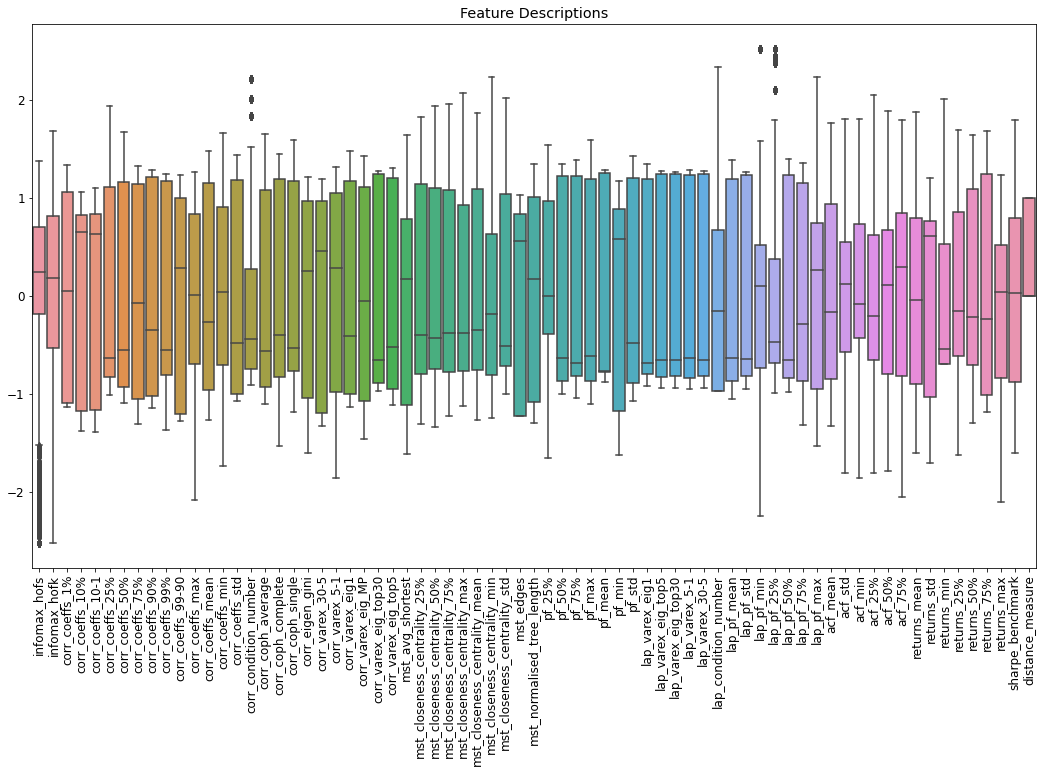

In [90]:
plt.figure(figsize=(18,10))
ax = sns.boxplot(data=xtrain_scaled)
plt.xticks(rotation=90);
plt.title("Feature Descriptions");

In [91]:
from mlfinlab.sampling.bootstrapping import get_ind_mat_average_uniqueness, get_ind_matrix, seq_bootstrap
from sklearn.preprocessing import OneHotEncoder

conc_feature_df = algo_specific_df.loc[:, ~algo_specific_df.columns.isin(columns_to_ignore + oos_columns + is_columns + corr_cull_columns)].iloc[ytrain.index].copy()

ind_list = []

full_date_series = pd.date_range(start="2009-01-01",end="2018-01-01", freq='M')

for feat_conc in conc_feature_df.iterrows():
    ind_list.append(full_date_series.isin(pd.date_range(start=feat_conc[1]['train_period_start'],end=feat_conc[1]['train_period_end'], freq='M')).astype(int))

crude_ind_df = pd.DataFrame(ind_list)#.iloc[chosen_sample_indices, :]

ind_mat = crude_ind_df.values

In [92]:
periphery_features = xtrain_scaled.columns #= pd.Series(periphery_features)#.append('clust_algo')

# periphery_features = periphery_features[periphery_features == 'clust_algo'].values

In [128]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import class_weight

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, BaggingRegressor,
                              GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor,
                              ExtraTreesClassifier)
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix

from sklearn.metrics import mean_squared_error


clf_est_params = {
    'criterion': 'mse',
    'n_estimators': 100, 
    'max_depth': 7,
    'bootstrap': True, 
    'max_features': 1,
    'max_samples': get_ind_mat_average_uniqueness(ind_mat),     
    'min_weight_fraction_leaf': 0.05,
    'oob_score':True,
    'random_state': random_state
}

# Use tools
clf = RandomForestRegressor()
clf.set_params(**clf_est_params)

# periphery_features = periphery_features[fdr_obj.get_support()]
clf.fit(xtrain_scaled.loc[:, periphery_features], ytrain)

print('MSE on train set:', mean_squared_error(clf.predict(xtrain_scaled.loc[:, periphery_features]), ytrain))
print('MSE on test set:', mean_squared_error(clf.predict(xvalidate_scaled.loc[:, periphery_features]), yvalidate))


MSE on train set: 0.049065619789119025
MSE on test set: 0.0509740359150434


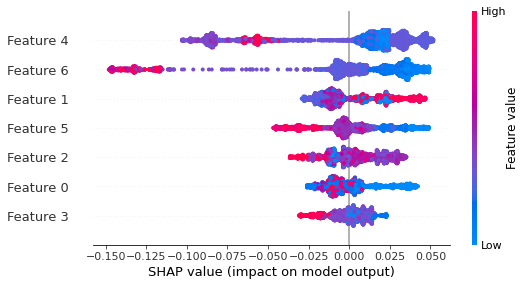

In [129]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(xtrain_scaled.loc[:, periphery_features])#, approximate=True)

shap.summary_plot(shap_values, xtrain_scaled.loc[:, periphery_features])


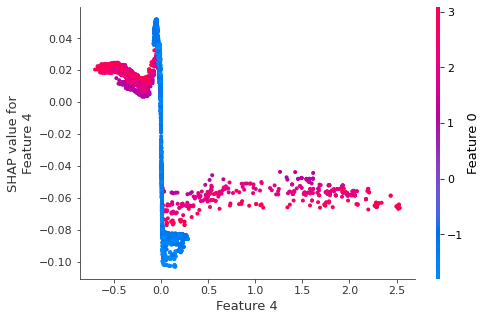

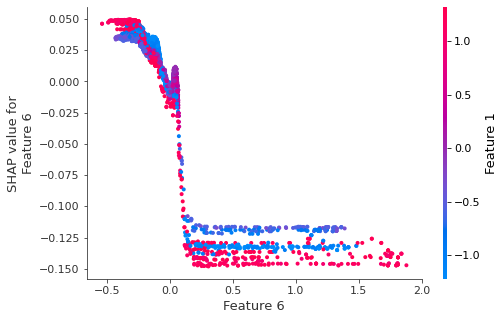

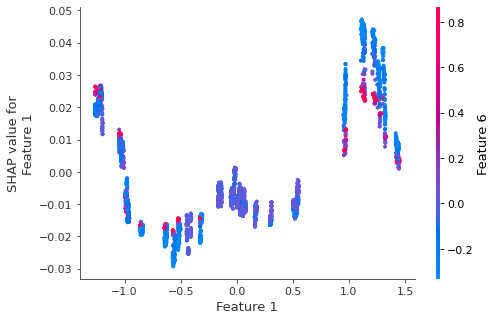

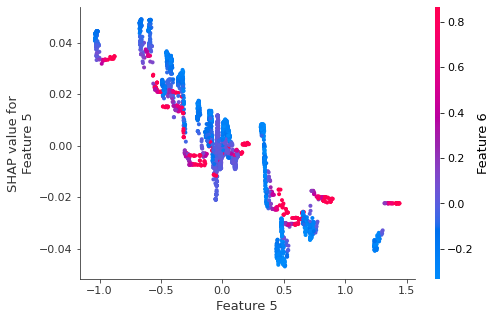

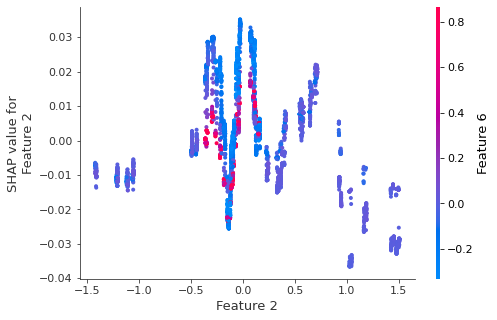

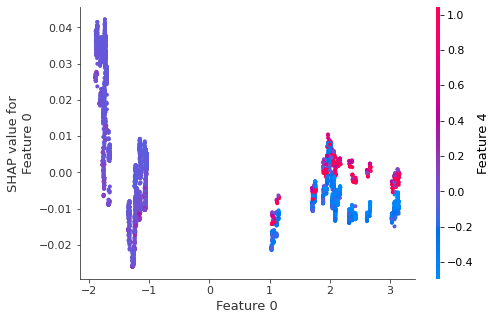

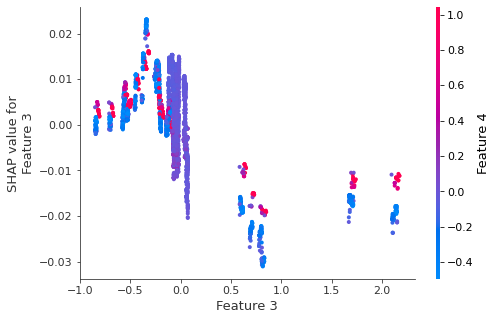

IndexError: index 7 is out of bounds for axis 0 with size 7

In [132]:
# inds = shap.approximate_interactions("mst_avg_shortest", shap_values, xtrain_scaled.loc[:, periphery_features])
for i in range(10): #[i] # interaction_index=inds[i],
    shap.dependence_plot('rank(' + str(i) + ')', shap_values, xtrain_scaled.loc[:, periphery_features], x_jitter=1) #rank(0)

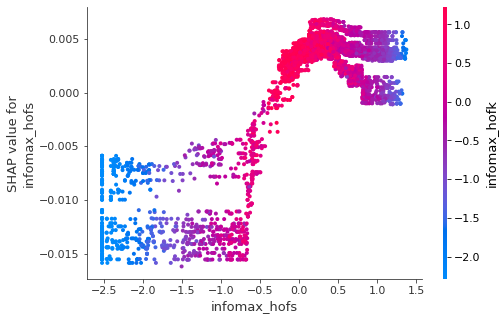

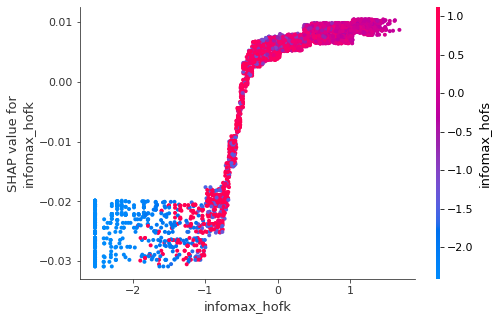

In [99]:
shap.dependence_plot('infomax_hofs', shap_values, xtrain_scaled.loc[:, periphery_features], interaction_index='infomax_hofk');
shap.dependence_plot('infomax_hofk', shap_values, xtrain_scaled.loc[:, periphery_features], interaction_index='infomax_hofs')